# Section IV - MNIST


In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.utils import shuffle

# personal code
import helpers as HL
import plot_functions as PL
import pickle_functions as PK

#magic
%load_ext autoreload
%autoreload 2

#constants
folder="mnist_pickles"
nb_samples = 1000
grid_width = 24

-----
-----
## A. The dataset

### Description
MNIST is a database of 70.000 samples of handwritten digits. The digits are represented with a 28x28 matrix with pixels. The pixels are of grayscale value with range [0,255]. The MNIST dataset is a subset from the bigger NIST dataset with a range of image preprocessing algorithms applied to it.



In [2]:
# Loading dataset
inputs, targets = HL.import_mnist()

# some constanst
n_samples, n_features = inputs.shape
n_neighbors = 30
pixel_width = int(np.sqrt(inputs.shape[1]))
print("pixel_width of each image: ", pixel_width)
print("range of grayscale pixel values: [{},{}]".format(inputs.min(), inputs.max()))


inputs shape:  (70000, 784)
targets shape:  (70000,)
pixel_width of each image:  28
range of grayscale pixel values: [0,255]


### Samples from MNIST

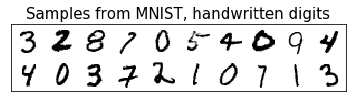

In [3]:
PL.plot_digits_samples(inputs, row_dim=2, col_dim=10)

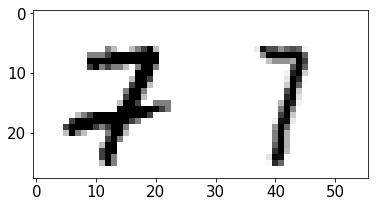

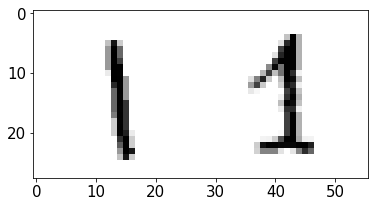

In [4]:
# show differences in 7's
X_7 = HL.get_X_with_label(inputs, targets, 7)
plt.imshow(np.hstack((X_7[1].reshape((pixel_width,pixel_width)), X_7[2].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()
# show differences in 1's
X_1 = HL.get_X_with_label(inputs, targets, 1)
plt.imshow(np.hstack((X_1[1].reshape((pixel_width,pixel_width)), X_1[316].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

Here we can see some of the variations one could expect from handwritten digits. There are different types of writing. The seven can be written with or without a crossbar at the top image. Some ones are written with a bottom crossbar like the one to right some are not. These are just one of the variations we can occur in the 

------
### Small note of what to come:
In the next sections we will investigate the hyperparameters effect on LLE creating a good embedding of MNIST-dataset.
We will also talk about how the embedding actually perform. 

###### Our qualitatively measure of "goodness" of embedding:
- it embeds the samples within one cluster close to each other. 
- it keeps classes that are can be similar in writing close to each other like $4$ and $9$. 
- the embedding shows in-class variations clustered within.

In this notebook, a dataset with 1000 samples from MNIST is used and seeds and random state is set to '123'. If nothing else is specified, all hyperparameters are set to their default value. 

------
## B. LLE

----
### Accuracy analysis of hyperparameters
The MNIST dataset is labeled, so K-means and F1 measure is used to evaluate the performance of LLE and t-SNE. For a grid of hyperparameters, each transformation is divided into ten clusters using K-means, thereafter the cluster label is decided by maximizing F1 score for each class. The most promising combination of hyperparameters is thereafter used to investigate the optimal number of clusters. The F1 score is calculated according to http://lasa.epfl.ch/teaching/lectures/ML_MSc_Advanced/Slides/F-Measure-Clustering.pdf. 
The kmeans initialization is also controlled by running several kmeans with seed numbers.

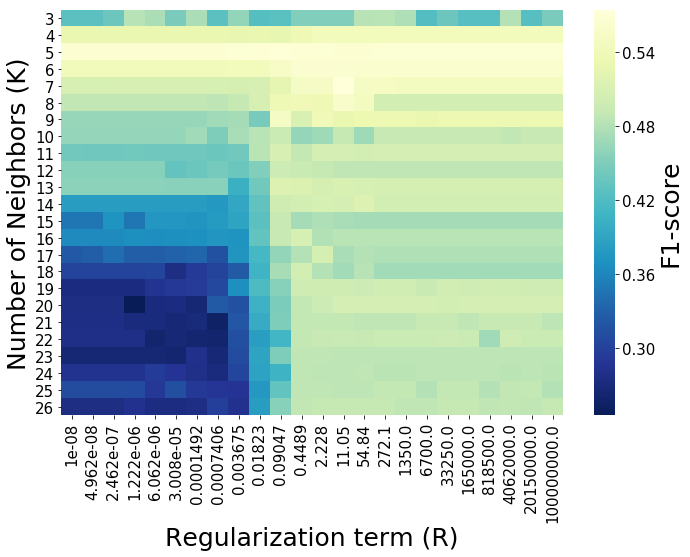

In [5]:
test_lle_dict = PK.kmeans_clustering_f1_measure(inputs, targets, "lle", grid_width=grid_width, nb_samples=nb_samples,
                                         reg_range=(-8, 8), neighbor_range=(3,26), plot=True, create=False)

### Discussion of heatmap
LLE is applied to the MNIST dataset, testing a grid of values of $R$ and $K$. The F1-score of every combination is presented in a figure above. The figure above suggests that the LLE is performing relatively bad with $K \in [3,15]$ combined with low regularization term $R \in [1e-10,0.01823]$. The F1 score is high for $K = [23,25]$, regardless of regularization term. For $R>0.4489$ the F1 score is quite high for all values of $K$, except for $K=26$. It is interesting to note that these observations are to some extent consistent with the assessment of transformations of the Swiss roll.\newline


-----
### LLE-embedding with interesting hyperparameters
given the accuracy analysis of the hyperparameters we want to take a closer look on what their effect is in a couple of different embeddings.

In [7]:
nb_components = 2
# parameters of interest
nb_neighbors = (5,19)
regs = (2.46209240149e-07, 1350.31403787)

X_lle_1 = manifold.LocallyLinearEmbedding(nb_neighbors[0], nb_components, reg=regs[0], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_2 = manifold.LocallyLinearEmbedding(nb_neighbors[0], nb_components, reg=regs[1], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_3 = manifold.LocallyLinearEmbedding(nb_neighbors[1], nb_components, reg=regs[0], method='standard') \
                  .fit_transform(inputs[0:nb_samples])
X_lle_4 = manifold.LocallyLinearEmbedding(nb_neighbors[1], nb_components, reg=regs[1], method='standard') \
                  .fit_transform(inputs[0:nb_samples])


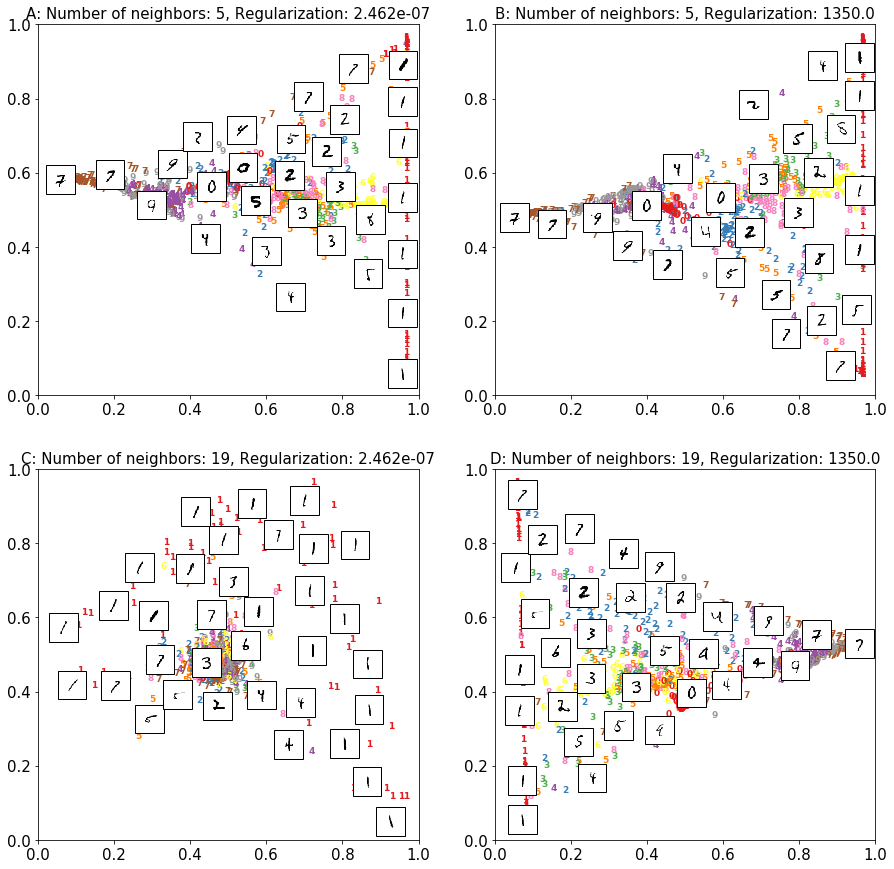

In [8]:
#parameters:
im = True # whether or not to show images
t = 9e-3 # how close the images should be shown

fig = plt.figure(figsize=(15,15))
l_ax1 = PL.plot_embedding(inputs, X_lle_1, targets[0:nb_samples], fig=fig, subplot_pos=221, images=im, im_thres=t, title="A: Number of neighbors: "+str(nb_neighbors[0])+", Regularization: "+str(HL.round_sig(regs[0])))
l_ax2 = PL.plot_embedding(inputs, X_lle_2, targets[0:nb_samples], fig=fig, subplot_pos=222, images=im, im_thres=t, title="B: Number of neighbors: "+str(nb_neighbors[0])+", Regularization: "+str(HL.round_sig(regs[1])))
l_ax3 = PL.plot_embedding(inputs, X_lle_3, targets[0:nb_samples], fig=fig, subplot_pos=223, images=im, im_thres=t, title="C: Number of neighbors: "+str(nb_neighbors[1])+", Regularization: "+str(HL.round_sig(regs[0])))
l_ax4 = PL.plot_embedding(inputs, X_lle_4, targets[0:nb_samples], fig=fig, subplot_pos=224, images=im, im_thres=t, title="D: Number of neighbors: "+str(nb_neighbors[1])+", Regularization: "+str(HL.round_sig(regs[1])))
#plt.savefig("images/MNIST_lle_embeddings")
plt.show()


### Notes of embeddings

Tendancies:
hyperparameters effect:
- has a very defined triangle structure with low K and/or high R
- high nb_neighbors might make crowding problem more probable
- high nb_neighbors gives less structured(triangle) embedding
- high nb_neigh and low reg gives bad results in accuracy and the embedding only focus on showing the variance of class 1

overall LLE:
- looks like LLE emdeds rotation pretty well

### LLE embedding with optimized hyperparameters
When finding the optimal hyperparameters for this embedding. The previous analysises are useful. Ruling out hyperparameters that scores very badly in the accuracy score and insight in the different hyperparameters effect guides us to our thought to be optimal embedding.

###### Our qualitatively measure of "goodness" of embedding:
- it embeds the samples within one cluster close to each other. 
- it keeps classes that are can be similar in writing close to each other like $4$ and $9$. 
- the embedding shows in-class variations clustered within.



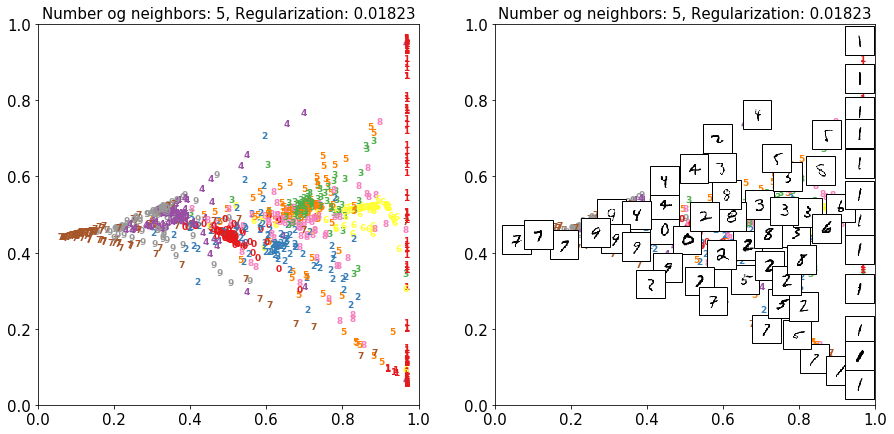

In [9]:
# best so far (n = 5, reg = 0.0182334800087) (n=9, reg = 0.0904735724235)
#parameters:
t = 3e-3 # how close the images should be shown
nb_components = 2

n = 5
reg = 0.0182334800087
fig = plt.figure(figsize=(15,7))
best_lle = manifold.LocallyLinearEmbedding(n, nb_components, reg, method='standard') \
                  .fit_transform(inputs[0:nb_samples])

best_lle_ax_1 = PL.plot_embedding(inputs, best_lle, targets[0:nb_samples], fig=fig, subplot_pos=121, images=False, im_thres=t, title="Number og neighbors: "+str(n)+", Regularization: "+str(HL.round_sig(reg)))
best_lle_ax_2 = PL.plot_embedding(inputs, best_lle, targets[0:nb_samples], fig=fig, subplot_pos=122, images=True, im_thres=t, title="Number og neighbors: "+str(n)+", Regularization: "+str(HL.round_sig(reg)))
#plt.savefig("images/MNIST_opt_lle_embedding")
plt.show()

### Discussion of LLE's optimal embedding
pros:
- fast
- handles skewness well
- Seems like it has predictable hyperparameter tuning

cons: 
- needs tuning for number of neighbors
- have trouble embedding the more complex classes with curves etc. like 3 and 8
- crowds at certain points


-----
-----

## C. t-SNE

Now same analysis with t-SNE

----
### Accuracy analysis of hyperparameters
- heatmap with perplexity and min_grad_norm with F1-score of kmeans(cluster=10) at in each point


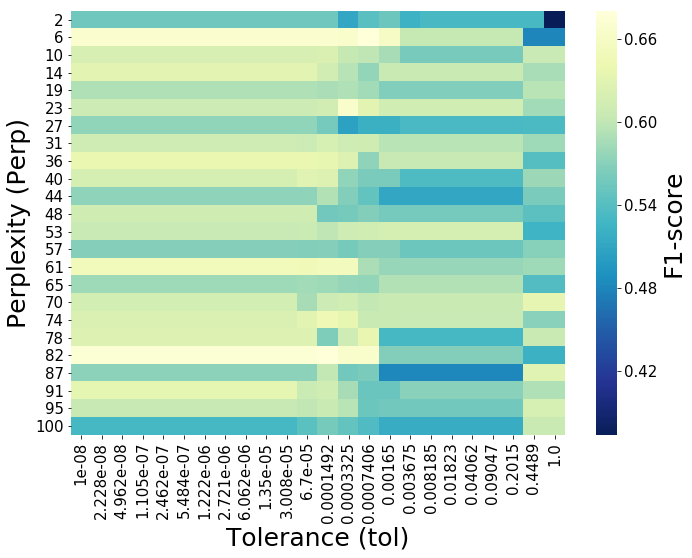

In [10]:
tsne_dict = PK.kmeans_clustering_f1_measure(inputs, targets, "tsne", grid_width=grid_width, nb_samples=nb_samples,
                                          min_grad_norm_range=(-8,0), perplexity_range=(2,100), plot=True, create=False)

### Discussion of heatmap
From this heatmap it is clear that t-SNE is fairly robust in changes $tol$, as long as $tol < 6.7 e-5$.  From investigation carried out in Section B it appears that $tol > 10 e-3$ significantly reduces the computational time, however, in this situation,  with $tol > 10 e-3$ one has to be more careful when picking $Perp$ and optimal F1 score is not reached.

-----
### LLE-embedding with interesting hyperparameters
given the accuracy analysis of the hyperparameters we want to take a closer look on what their effect is in a couple of different embeddings.

In [12]:
# parameters of interest
perplexity = (23,82)
min_grad_norm = (4.961947603e-08, 0.000332459793227) # then test 0.448925125822 then 100

X_tsne_1 = manifold.TSNE(n_components=2, perplexity=perplexity[0], min_grad_norm=min_grad_norm[0], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_2 = manifold.TSNE(n_components=2, perplexity=perplexity[0], min_grad_norm=min_grad_norm[1], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_3 = manifold.TSNE(n_components=2, perplexity=perplexity[1], min_grad_norm=min_grad_norm[0], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
X_tsne_4 = manifold.TSNE(n_components=2, perplexity=perplexity[1], min_grad_norm=min_grad_norm[1], init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])


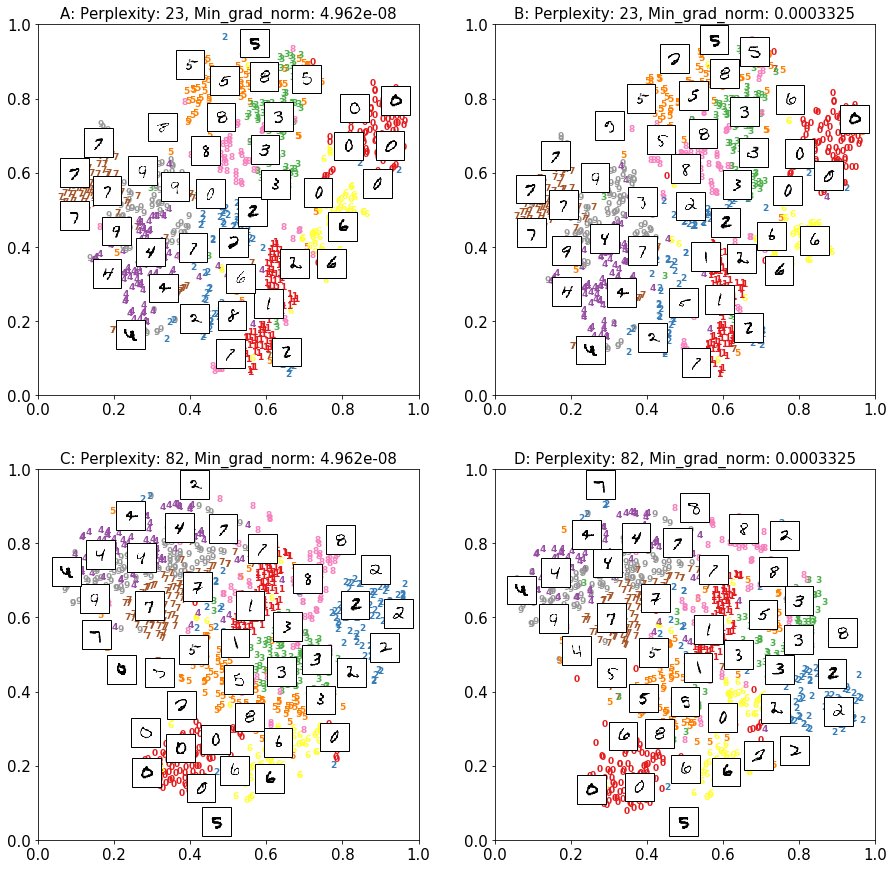

In [13]:
# parameters
im = True # whether or not to show images
t = 9e-3 # how close the images should be shown

fig = plt.figure(figsize=(15,15))
t_ax1 = PL.plot_embedding(inputs, X_tsne_1, targets[0:nb_samples], fig=fig, subplot_pos=221, images=im, im_thres=t, title="A: Perplexity: "+str(perplexity[0])+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm[0])))
t_ax2 = PL.plot_embedding(inputs, X_tsne_2, targets[0:nb_samples], fig=fig, subplot_pos=222, images=im, im_thres=t, title="B: Perplexity: "+str(perplexity[0])+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm[1])))
t_ax3 = PL.plot_embedding(inputs, X_tsne_3, targets[0:nb_samples], fig=fig, subplot_pos=223, images=im, im_thres=t, title="C: Perplexity: "+str(perplexity[1])+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm[0])))
t_ax4 = PL.plot_embedding(inputs, X_tsne_4, targets[0:nb_samples], fig=fig, subplot_pos=224, images=im, im_thres=t, title="D: Perplexity: "+str(perplexity[1])+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm[1])))
#plt.savefig("images/MNIST_tsne_embeddings")
plt.show()

### Notes from embeddings
- pretty robust to very different perplexities and regularization, different but not bad
- The plot with lower perplexity is much more clustered with more distance between clusters.
- The plots with higher perplexity are more continous and not bad
- generally good solutions


### t-SNE embedding with optimized hyperparameters
When finding the optimal hyperparameters for this embedding. The previous analysises are useful. Ruling out hyperparameters that scores very badly in the accuracy score and insight in the different hyperparameters effect guides us to our thought to be the best embedding.

###### Our qualitatively measure of "goodness" of embedding:
- it embeds the samples within one cluster close to each other. 
- it keeps classes that are can be similar in writing close to each other like $4$ and $9$. 
- the embedding shows in-class variations clustered within.

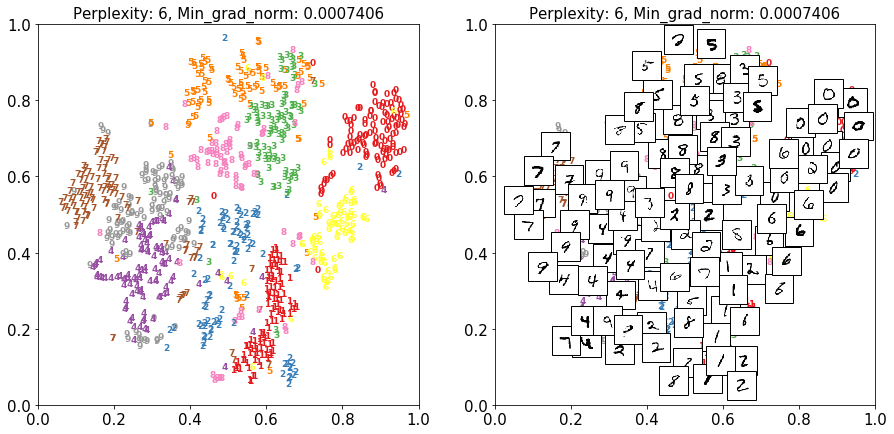

In [15]:
#parameters:
t = 3e-3 # how close the images should be shown
nb_components = 2

perplexity = 6
min_grad_norm = 0.000740568469226
fig = plt.figure(figsize=(15,7))
best_tsne = manifold.TSNE(n_components=2, perplexity=perplexity, min_grad_norm=min_grad_norm, init='random', random_state=123) \
.fit_transform(inputs[0:nb_samples])

best_tsne_ax_1 = PL.plot_embedding(inputs, X_tsne_1, targets[0:nb_samples], fig=fig, subplot_pos=121, images=False, im_thres=t, title="Perplexity: "+str(perplexity)+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm)))
best_tsne_ax_2 = PL.plot_embedding(inputs, X_tsne_1, targets[0:nb_samples], fig=fig, subplot_pos=122, images=True, im_thres=t, title="Perplexity: "+str(perplexity)+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm)))
#plt.savefig("images/MNIST_opt_tsne_embedding")
plt.show()

### Discussion of LLE's optimal embedding
pros
- captures the clusters very well
- captures in-class variations as the rotation within class 1. or the different ways to write class 2 in the right picture
- robust to hyperparameters

cons
- computational time

-----------------------
### Conclusion
Except from computational time t-SNE is superior to LLE on the MNIST dataset.

### Appendix: plotting for report

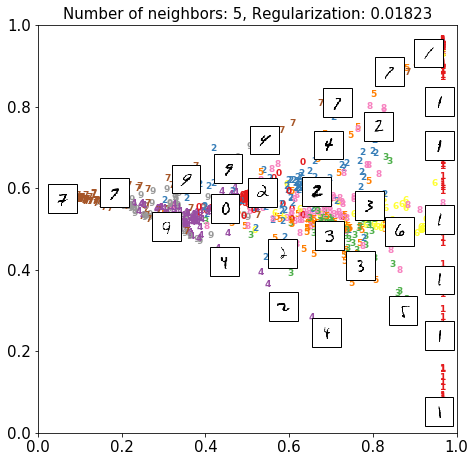

In [19]:
################# JUST FOR REPORT ##################################
################# JUST FOR REPORT ##################################
nb_components = 2
# parameters of interest
nb_neighbors = 5  # 5 , 19
regs =  0.0182334800087 #0.0182334800087 , 2.46209240149e-07
X_lle_p = manifold.LocallyLinearEmbedding(nb_neighbors, nb_components, reg=regs, method='standard') \
                  .fit_transform(inputs[0:nb_samples])
#parameters:
im = True # whether or not to show images
t = 9e-3 # how close the images should be shown

fig = plt.figure(figsize=(7.5,7.5))
ax = PL.plot_embedding(inputs, X_lle_p, targets[0:nb_samples], fig=fig, subplot_pos=111, images=im, im_thres=t, title="Number of neighbors: "+str(nb_neighbors)+", Regularization: "+str(HL.round_sig(regs)))
plt.savefig("images/MNIST_lle_best") #"images/MNIST_lle_best" "images/MNIST_lle_highK"
plt.show()
################# JUST FOR REPORT ##################################
################# JUST FOR REPORT ##################################

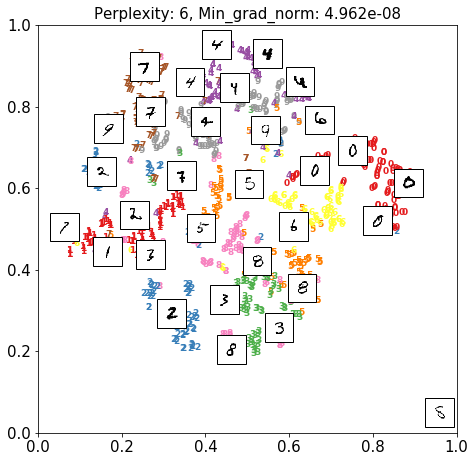

In [20]:
################# JUST FOR REPORT ##################################
################# JUST FOR REPORT ##################################
# parameters of interest
perplexity = 6 # 6, 82
min_grad_norm = 4.961947603e-08 # 4.961947603e-08 , 4.961947603e-08

X_tsne_p = manifold.TSNE(n_components=2, perplexity=perplexity, min_grad_norm=min_grad_norm, init='random', random_state=123) \
                   .fit_transform(inputs[0:nb_samples])
#parameters:
im = True # whether or not to show images
t = 1e-2 # how close the images should be shown

fig = plt.figure(figsize=(7.5,7.5))
ax1 = PL.plot_embedding(inputs, X_tsne_p, targets[0:nb_samples], fig=fig, subplot_pos=111, images=im, im_thres=t, title="Perplexity: "+str(perplexity)+", Min_grad_norm: "+str(HL.round_sig(min_grad_norm)))
plt.savefig("images/MNIST_tsne_best") #"images/MNIST_tsne_best" "images/MNIST_tsne_lowPerplexity"
plt.show()
################# JUST FOR REPORT ##################################
################# JUST FOR REPORT ##################################